[*********************100%***********************]  1 of 1 completed


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
R²: 0.2733
MAE: $12.16
RMSE: $14.75


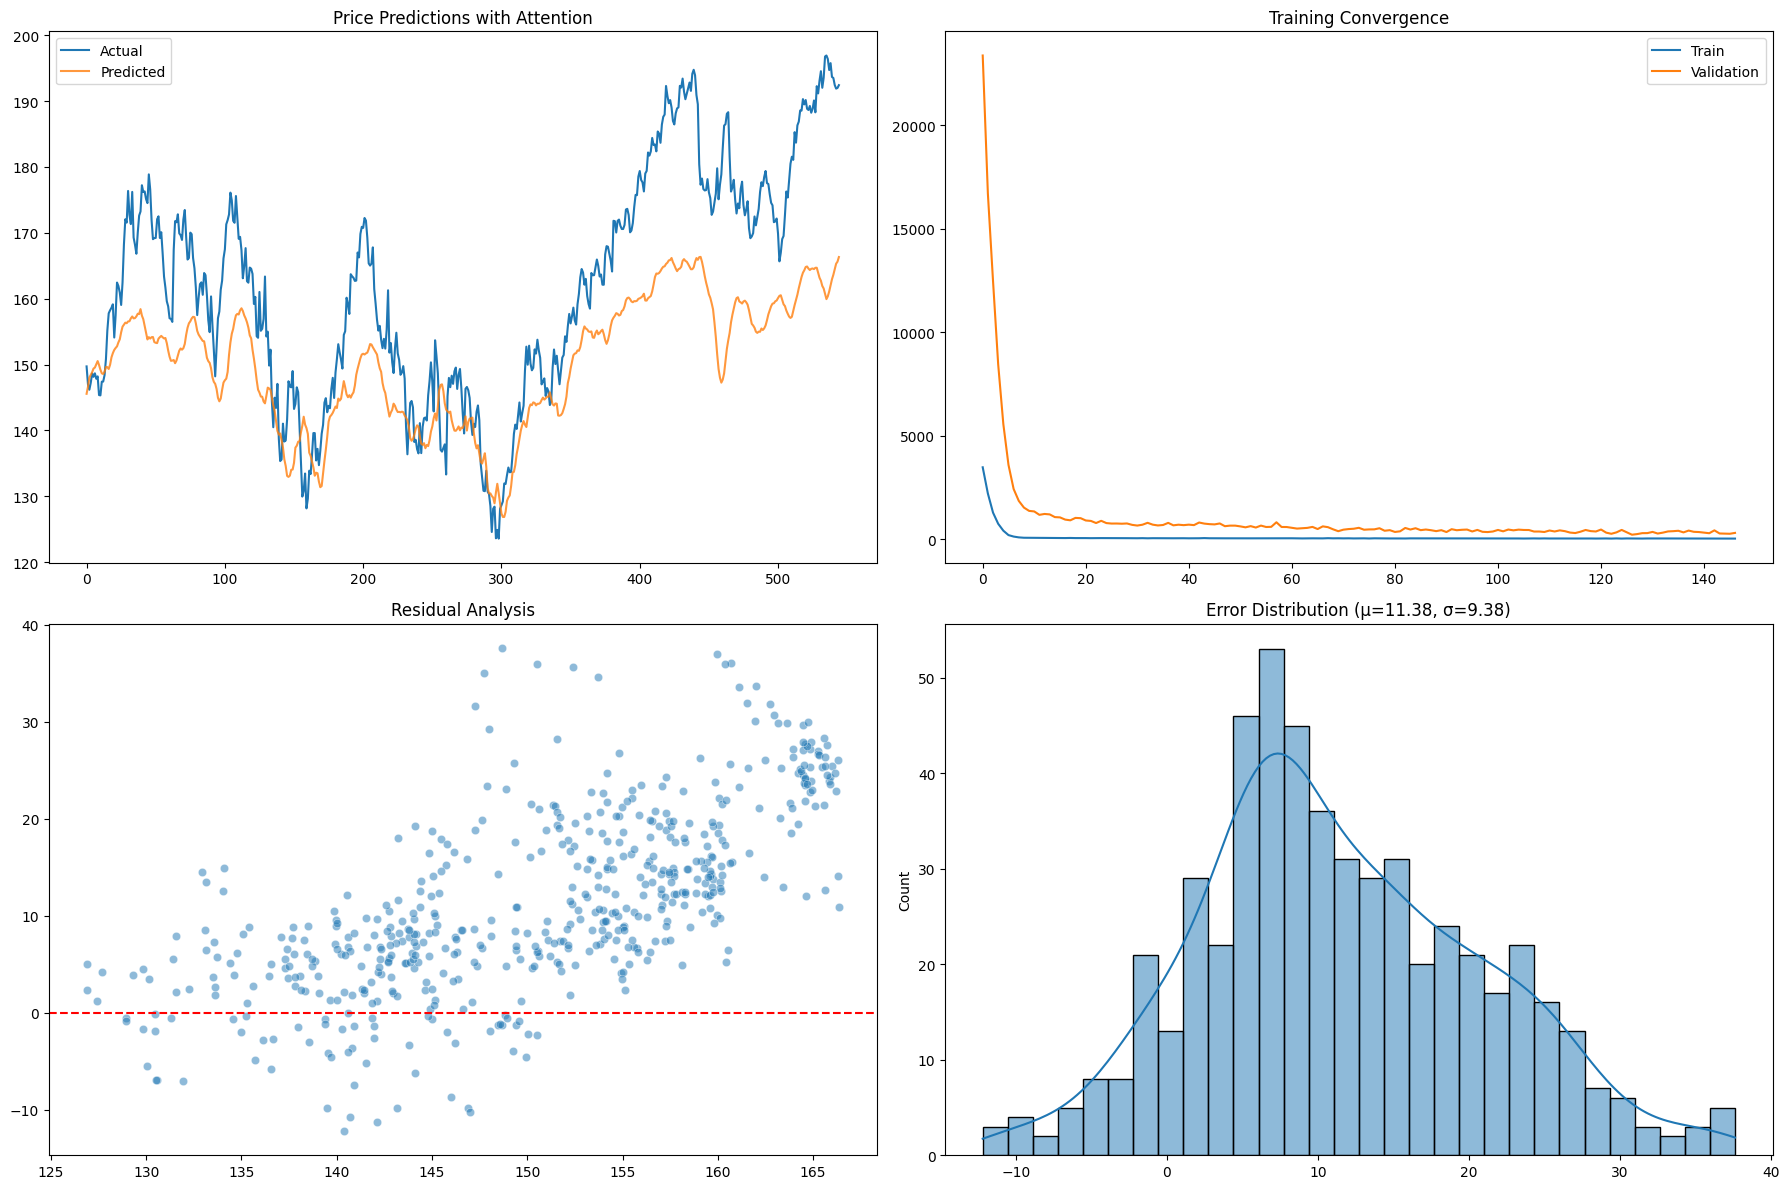

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Download and prepare data
df = yf.download('AAPL', start='2013-01-01', end='2023-12-31')[['Close', 'Volume']]

# Feature Engineering (same as before)
def create_features(df):
    df['Close_MA7'] = df['Close'].rolling(7).mean()
    df['Close_MA21'] = df['Close'].rolling(21).mean()
    df['Momentum_14'] = df['Close'].diff(14)
    df['Volume_ROC7'] = df['Volume'].pct_change(7)
    df['Vol_Price'] = df['Volume'] * df['Close']
    df['Volatility_14'] = df['Close'].pct_change().rolling(14).std()
    df['Target'] = df['Close'].shift(-1)
    return df.dropna()

df = create_features(df)

# Data Preparation (same as before)
features = df.drop(columns=['Target'])
target = df['Target']
scaler = RobustScaler()
scaled_features = scaler.fit_transform(features)

# Sequence Creation (same as before)
SEQ_LEN = 21
def create_sequences(features, target, seq_length):
    X, y = [], []
    for i in range(len(features)-seq_length-1):
        X.append(features[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_features, target.values, SEQ_LEN)

# Train-Test Split (same as before)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Modified Model with Attention
def create_attention_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # LSTM layer with return_sequences=True
    lstm_out = layers.LSTM(64, return_sequences=True)(inputs)

    # Attention Mechanism
    attention = layers.Dense(1, activation='tanh')(lstm_out)
    attention = layers.Flatten()(attention)
    attention = layers.Activation('softmax')(attention)
    attention = layers.RepeatVector(64)(attention)
    attention = layers.Permute([2, 1])(attention)

    context = layers.Multiply()([lstm_out, attention])
    context = layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(context)

    # Additional layers
    x = layers.Dropout(0.4)(context)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)

    return Model(inputs=inputs, outputs=outputs)

model = create_attention_model((SEQ_LEN, X.shape[2]))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse'
)

# Training (same parameters)
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
    ],
    verbose=0
)

# Predictions and Evaluation (same as before)
y_pred = model.predict(X_test).flatten()
print(f"R²: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: ${mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

# Visualization (same as before)
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted', alpha=0.8)
plt.title('Price Predictions with Attention')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Training Convergence')
plt.legend()

plt.subplot(2, 2, 3)
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Analysis')

plt.subplot(2, 2, 4)
sns.histplot(residuals, kde=True, bins=30)
plt.title(f'Error Distribution (μ={np.mean(residuals):.2f}, σ={np.std(residuals):.2f})')

plt.tight_layout()
plt.show()